In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dtaidistance import dtw, dtw_c, dtw_ndim
from numpy.random import choice, shuffle
from torch import nn
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
%load_ext autoreload
%autoreload 1

from preprocessing import *
from models import Encoder, Decoder, Sequence2Sequence

%aimport preprocessing
%aimport models

# Example of multidimensional time-series

In [3]:
# !mkdir -p data
# !wget https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/UCRArchive_2018.zip ../data
# !unzip data/UCRArchive_2018.zip -d ../data

In [4]:
# data_path = "../data/UCRArchive_2018/Earthquakes/Earthquakes_TRAIN.tsv"

In [5]:
# data = pd.read_csv(data_path, header=None, delimiter="\t").values

# # to remove Nan (only first columns)
# data = data[:, ~np.isnan(data).any(0)]

# X = data[:, 1:]
# y = data[:, 0].astype(np.short)

# B_Accelerometer preprocessing

[Link](https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip "")

In [254]:
import os

SAMPLE_SIZE = 200
LABELS = [0, 1, 4, 5]
LENGTH = 100


labels = np.unique([x[:3] for x in os.listdir("../data/B_Accelerometer_data/")])
dirs = os.listdir("../data/B_Accelerometer_data/")
d = dict((label, i) for (i, label) in enumerate(labels))

timeseries = {label: [] for label in d.values()}

for dir_name in dirs:
    tmp = []
    for f in os.listdir("../data/B_Accelerometer_data/{}".format(dir_name)):
        data = pd.read_csv("../data/B_Accelerometer_data/{}/{}".format(dir_name, f), index_col=0)

        tmp.append(np.linalg.norm(data, axis=1))
        
    timeseries[d[dir_name[:3]]] = zscore(np.hstack(tmp))

dataset = {label: [] for label in LABELS}
for label in LABELS:
    X = timeseries[label][np.newaxis].T
    dataset[label].extend(slice_timeseries(X, LENGTH))
    
    
max_count = min([len(x) for x in dataset.values()])
for label, ts in dataset.items():
    dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]
    
X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
X = np.hstack(X).T
y = np.hstack(y).T

In [112]:
# fig, axs = plt.subplots(len(LABELS), figsize=(10, 15))

# for i, label in enumerate(LABELS):
#     axs[i].plot(dataset[label][10])

# Accelerometer dataset 

- 1: Working at Computer
- 2: Standing Up, Walking and Going up\down stairs
- 3: Standing
- 4: Walking
- 5: Going Up\Down Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

In [110]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O ../data/Accelerometer.zip
# ! unzip ../data/Accelerometer.zip -d ./data

In [67]:
CHANNELS = ['0', '1', '2']
LABELS = [1, 3, 4, 5]
LENGTH = 100
start_ident = 200

In [316]:
def get_dataset_3():
    np.random.seed(0)


    dataset = {label: [] for label in LABELS}

    for i in range(1, 11):
        data_path = "../data/Activity Recognition from Single Chest-Mounted Accelerometer/{0}.csv".format(i)
        data = pd.read_csv(data_path,
                       names=['0', '1', '2', "labels"],
                       index_col=0,
                       dtype=np.float)

        for label in LABELS:
            X = get_class_timeseries(label, data, start_ident)
            X = np.linalg.norm(X, axis=1)[np.newaxis].T
            dataset[label].extend(slice_timeseries(X, LENGTH))

    max_count = min([len(x) for x in dataset.values()])
    for label, ts in dataset.items():
        dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]

    X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
    y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
    X = np.hstack(X).T
    y = np.hstack(y).T
    
    return X, y

# Experiment

In [255]:
len(train_ds)

2405

In [256]:
len(valid_ds)

961

In [257]:
k=7
w=5

In [258]:
device = torch.device("cuda")

ds = SplittedDataset(X, y, k, w, device=device)
train_ds, test_ds, valid_ds = train_test_valid_split(ds, 0.3, 0.2)

train_set = DataLoader(train_ds, batch_size=1024, shuffle=True)
test_set = DataLoader(test_ds, batch_size=1024, shuffle=True)
valid_set = DataLoader(valid_ds, batch_size=400, shuffle=True)

In [317]:
from models import Encoder, Decoder, Sequence2Sequence

input_dim = 2*k
hidden_dim = 6
n_layers = 5

enc = Encoder(input_dim, hidden_dim, 1, n_layers, False)
dec = Decoder(hidden_dim, input_dim, 1, n_layers)

In [318]:
model = Sequence2Sequence(enc, dec)
model.to(device)

Sequence2Sequence(
  (encoder): Encoder(
    (lstm): LSTM(14, 6, num_layers=5)
  )
  (decoder): Decoder(
    (lstm): LSTM(6, 14, num_layers=5)
  )
)

In [319]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [320]:
def train(model, train_ds, optim, valid_ds):
    model.train()
    for step in range(N_STEP):
        it = iter(train_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            optim.zero_grad()
            out = model(batch)
            loss = loss_fn(batch, out)

            if step % 100 == 0:
                print("Loss:", loss)

            loss.backward()
            optim.step()

            if step % 500 == 0:
                valid(model, valid_ds)
                model.train()

def valid(model, valid_ds):
    model.eval()
    with torch.no_grad():
        loss = 0.
        it = iter(valid_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            out = model(batch)
            loss += loss_fn(batch, out)
    
    print("Valid loss:", loss)

In [321]:
# model.load_state_dict(torch.load("../data/pretrained.pcl"))

In [322]:
N_STEP = 8000

train(model, train_set, optim, test_set)
torch.save(model.state_dict(), "../data/pretrained.pcl")

Loss: tensor(1.0151, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(1.0185, device='cuda:0')
Loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(1.0179, device='cuda:0')
Loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5515, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5571, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4980, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(0.5157, device='cuda:0')
Loss: tensor(0.5138, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(0.5157, device='cuda:0')
Loss: tensor(0.4821, device='cuda:0', grad_fn=<MeanBackward0>)
Loss:

In [323]:
valid(model, test_set)
valid_it = iter(valid_set)

Valid loss: tensor(0.3813, device='cuda:0')


In [324]:
batch, timeseries, labels = next(valid_it)
timeseries = timeseries.numpy()

In [325]:
hiddens.shape

(400, 18, 5)

In [326]:
id0 = 5
id1 = 5

x_out = model(batch.permute(1, 0, 2)).permute(1, 0, 2).cpu().detach().numpy()

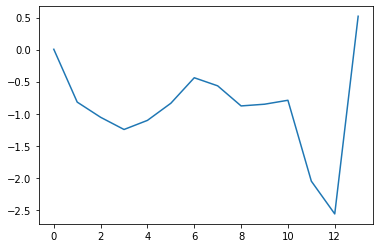

In [327]:
plt.plot(batch[id0, id1].cpu())

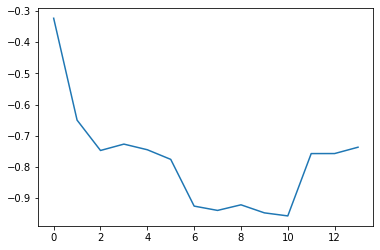

In [328]:
plt.plot(x_out[id0, id1])

In [329]:
def m(id1, id2, matrix):
    x, y = int(min(id1[0], id2[0])), int(max(id1[0], id2[0]))
    return matrix[x, y]

def get_metric(matrix):
    return lambda id1, id2: m(id1, id2, matrix)

In [357]:
idxs = np.arange(len(timeseries)).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.3)

In [344]:
from sklearn.neighbors import KNeighborsClassifier

## Classification on raw time-series

In [332]:
%%time
matrix_ts = dtw.distance_matrix(timeseries, use_c=True)

Wall time: 28min 18s


In [358]:
clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.75

## Hidden states classification

In [334]:
%%time
hiddens = model.encoder(batch.permute(1, 0, 2))[0].permute(1, 0, 2).detach().cpu().numpy()
matrix_hidden = dtw_ndim.distance_matrix(hiddens)

Wall time: 7min 2s


In [360]:
clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.6583333333333333

In [ ]:
scores_ts = []
scores_hidden = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(idxs, labels.cpu().numpy(), test_size=0.3)

    clf = KNeighborsClassifier(metric=get_metric(matrix_ts), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_ts.append(score)
    clf = KNeighborsClassifier(metric=get_metric(matrix_hidden), algorithm="brute")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores_hidden.append(score)
    
print("{:.3f}".format(np.mean(scores_ts)))    
print("{:.3f}".format(np.mean(scores_hidden)))